In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.inspection import permutation_importance
from scipy import stats

Let's load the dataset and print out it's head to get a reminder of what it looks like.

In [2]:
starcraft_data = pd.read_csv('wrangled_starcraft_data.csv')
starcraft_data.drop('Unnamed: 0', axis=1, inplace=True)
starcraft_data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Let's make a heatmap to see which variables correlate most to our target variable of League Index

In [3]:
#To make the data easier to read
plt.rcParams['figure.figsize'] = (10, 10)
sns.set()

Text(0.5, 1.0, 'Pearson Heat Map')

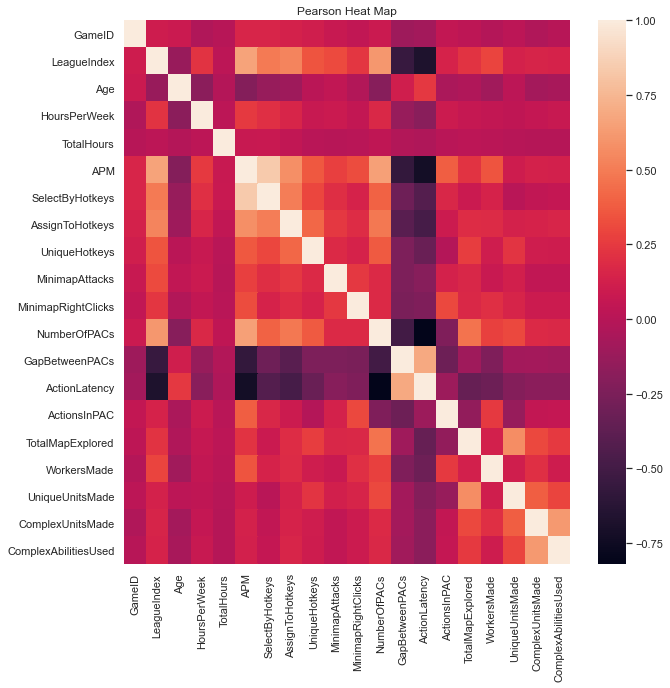

In [4]:
(sns.heatmap(starcraft_data.corr()).set_title('Pearson Heat Map'))

Text(0.5, 1.0, 'League Index Count Chart')

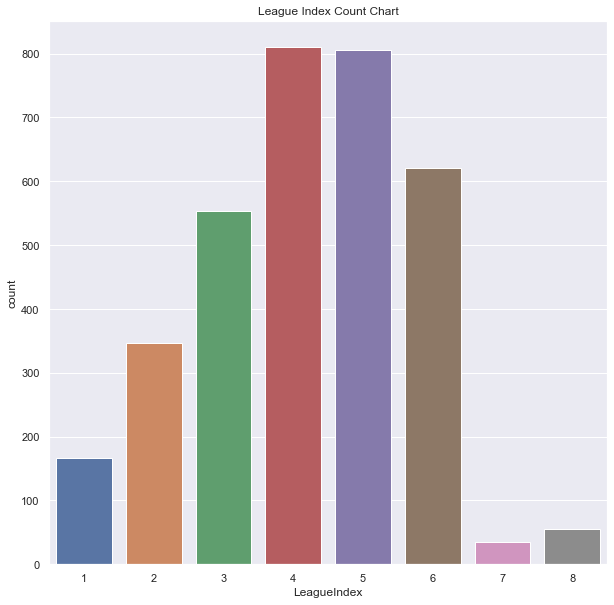

In [5]:
(sns.countplot(x=starcraft_data['LeagueIndex']).set_title('League Index Count Chart'))

Seems most of our data is coming from master and below. This would make sense as only 200 players from each reason are allowed in grandmaster each season and professionals typically belong in this league as well.

It seems that APM and Number of PACs have the highest positive correlations with League Index, while Action Latency and Gap Between PACs have the strongest negative correlations. At first glance, these things make sense. I have long been a starcraft enthusiast. I have spent many hours playing the game, studying the stratgies and trying to improve. One thing that was always mentioned was getting one's APM up, as a lot of professional players have an high APM. The speed at which one can process information and makes decisions correlating to a high League Index makes sense as well, this is what PAC is describing. It also makes sense that if one has bad internet connection or slow decision making skills their index would be lower. Let's explore these correlations further with some boxplots.

Text(0.5, 1.0, 'League Index vs APM')

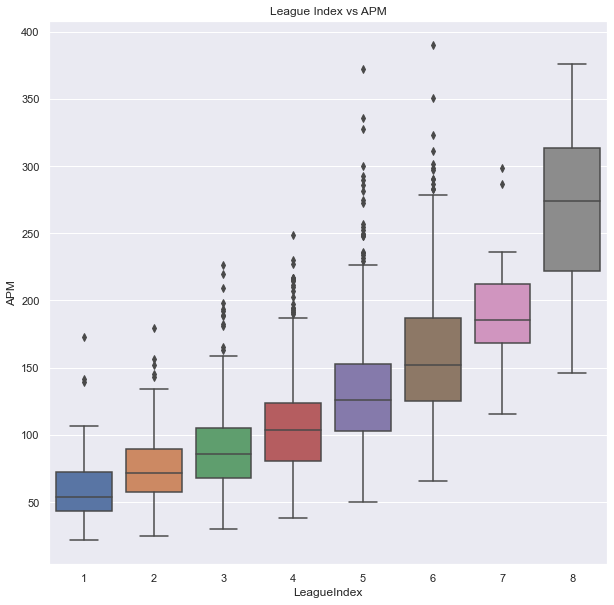

In [6]:
(sns.boxplot(x='LeagueIndex', y='APM', data=starcraft_data).set_title('League Index vs APM'))

In [7]:
def anovatest_nonorm(column):
    bronze = starcraft_data[column][starcraft_data['LeagueIndex']==1]
    silver = starcraft_data[column][starcraft_data['LeagueIndex']==2]
    gold = starcraft_data[column][starcraft_data['LeagueIndex']==3]
    platinum = starcraft_data[column][starcraft_data['LeagueIndex']==4]
    diamond = starcraft_data[column][starcraft_data['LeagueIndex']==5]
    master = starcraft_data[column][starcraft_data['LeagueIndex']==6]
    grandmaster = starcraft_data[column][starcraft_data['LeagueIndex']==7]
    pro = starcraft_data[column][starcraft_data['LeagueIndex']==8]
    return stats.f_oneway(bronze, silver, gold, platinum, diamond, master, grandmaster, pro)

In [8]:
#Will use this funciton to run anova tests for features vs League Index. 
#Boxcox is used to ensure data is close to normal. 
def anovatest(column):
    bronze, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==1])
    silver, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==2])
    gold, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==3])
    platinum, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==4])
    diamond, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==5])
    master, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==6])
    grandmaster, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==7])
    pro, fitted_lambda = stats.boxcox(starcraft_data[column][starcraft_data['LeagueIndex']==8])
    return stats.f_oneway(bronze, silver, gold, platinum, diamond, master, grandmaster, pro)

In [9]:
stats.ttest_ind(starcraft_data['APM'][starcraft_data['LeagueIndex']==7], 
                starcraft_data['APM'][starcraft_data['LeagueIndex']==8])

Ttest_indResult(statistic=-7.0826074526666964, pvalue=3.3138052521674904e-10)

In [10]:
anovatest('APM'), anovatest_nonorm('APM')

(F_onewayResult(statistic=6226.628341894563, pvalue=0.0),
 F_onewayResult(statistic=437.96631955731624, pvalue=0.0))

Tukey tests, t test could also be good. Anova. T test between 7 and 8

Text(0.5, 1.0, 'League Index vs Number of PACs')

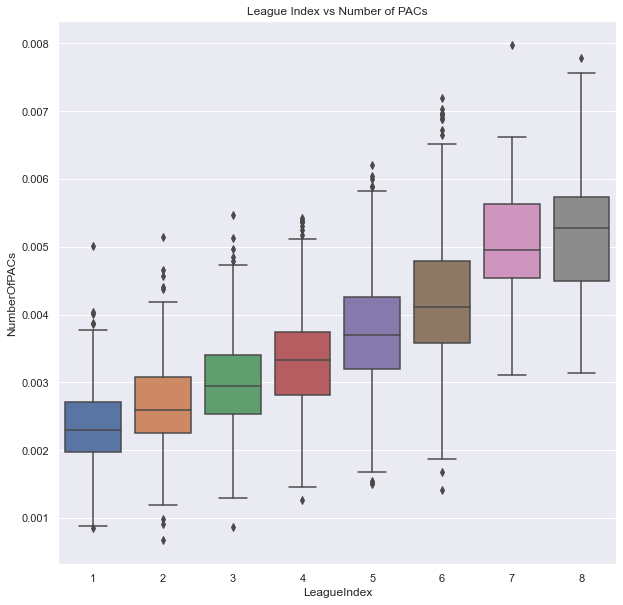

In [11]:

sns.boxplot(x='LeagueIndex', y='NumberOfPACs', data=starcraft_data).set_title('League Index vs Number of PACs')

In [12]:
anovatest('NumberOfPACs'), anovatest_nonorm('NumberOfPACs')

(F_onewayResult(statistic=505042.75342907524, pvalue=0.0),
 F_onewayResult(statistic=300.2497110659841, pvalue=0.0))

Text(0.5, 1.0, 'League Index vs Action Latency')

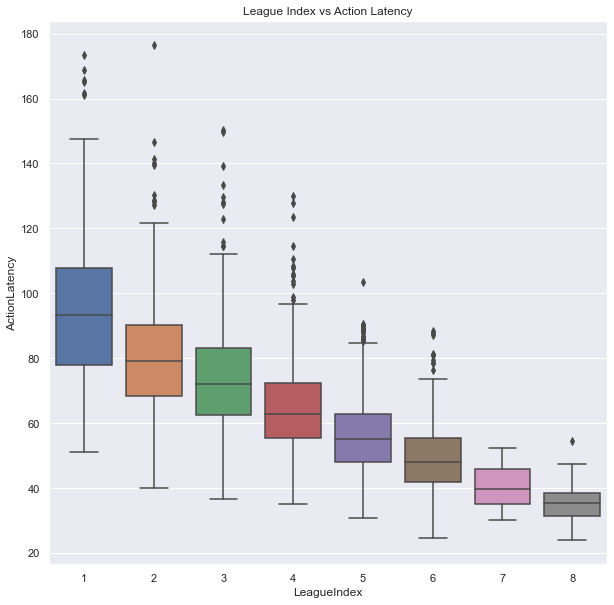

In [13]:
sns.boxplot(x='LeagueIndex', y='ActionLatency', data=starcraft_data).set_title('League Index vs Action Latency')

In [14]:
anovatest('ActionLatency'), anovatest_nonorm('ActionLatency')

(F_onewayResult(statistic=12608.578046744036, pvalue=0.0),
 F_onewayResult(statistic=410.08709338237446, pvalue=0.0))

Text(0.5, 1.0, 'League Index vs Gap Between PACs')

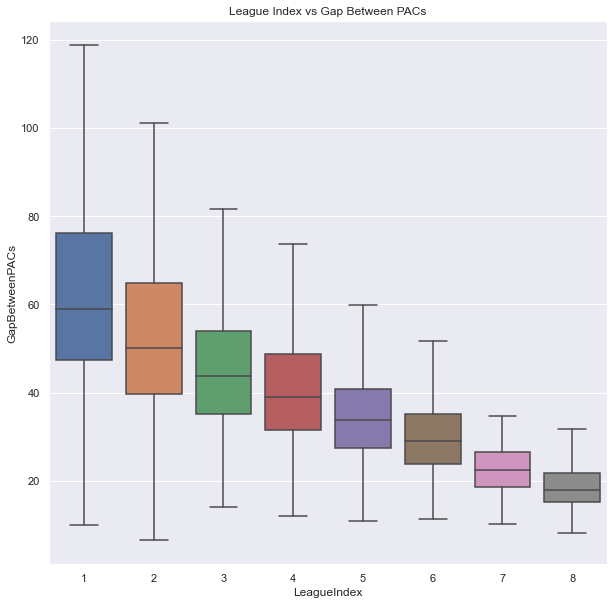

In [15]:
(sns.boxplot(x='LeagueIndex', y='GapBetweenPACs', data=starcraft_data, showfliers=False).set_title('League Index vs Gap Between PACs'))

In [16]:
anovatest('GapBetweenPACs'), anovatest_nonorm('GapBetweenPACs')

(F_onewayResult(statistic=1609.5394584409019, pvalue=0.0),
 F_onewayResult(statistic=221.52143391428575, pvalue=1.1502440184078454e-271))

The above varibles all seem important. Let's run a forest regressor algorithm to get a qunatative look at this.

In [17]:
#Need to fill in some NaN values for regressor to work. Going to fill with averages
starcraft_data_nanfree = starcraft_data.copy()
starcraft_data_nanfree['Age'] = starcraft_data_nanfree['Age'].fillna(starcraft_data_nanfree['Age'].mean())
starcraft_data_nanfree['HoursPerWeek'] = starcraft_data_nanfree['HoursPerWeek'].fillna(starcraft_data_nanfree['HoursPerWeek'].mean())
starcraft_data_nanfree['TotalHours'] = starcraft_data_nanfree['TotalHours'].fillna(starcraft_data_nanfree['TotalHours'].mean())

In [18]:
X = starcraft_data_nanfree.drop(['LeagueIndex', 'GameID'], axis=1)
y = starcraft_data_nanfree['LeagueIndex']
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=10)

In [19]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

Text(0.5, 0, 'Importance')

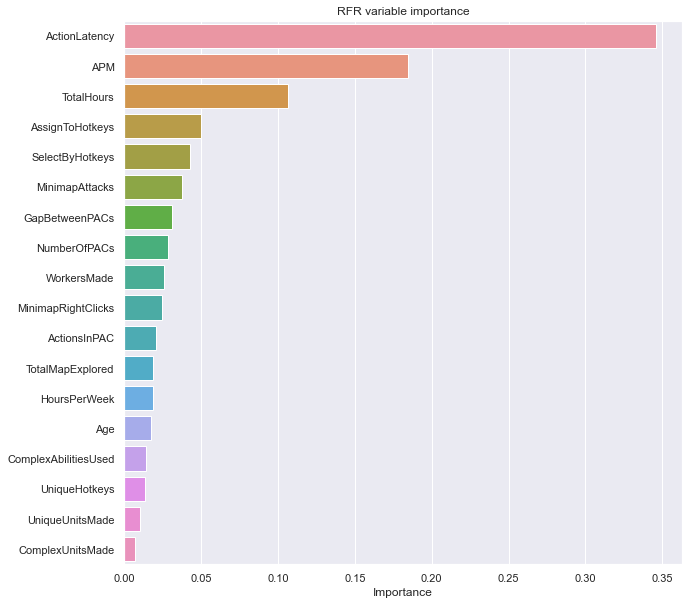

In [20]:
sorted_index_reg = (-forest_reg.feature_importances_).argsort()#This index will allow descending order
(sns.barplot(x=forest_reg.feature_importances_[sorted_index_reg], y=X.columns[sorted_index_reg])
            .set_title('RFR variable importance'))
plt.xlabel('Importance')

Text(0.5, 1.0, 'RFR Permutation Variable Importance')

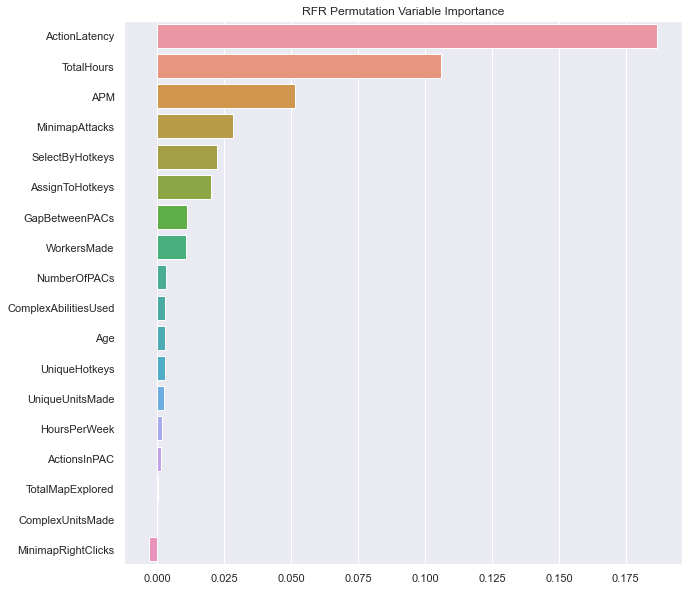

In [21]:
perm_impor_reg = permutation_importance(forest_reg, X_test, y_test)
perm_sort_index_reg = (-perm_impor_reg.importances_mean).argsort()
(sns.barplot(y=X.columns[perm_sort_index_reg], x=perm_impor_reg.importances_mean[perm_sort_index_reg])
             .set_title('RFR Permutation Variable Importance'))


In [22]:
forest_class = RandomForestClassifier(random_state=10)
forest_class.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

Text(0.5, 1.0, 'RFC variable importance')

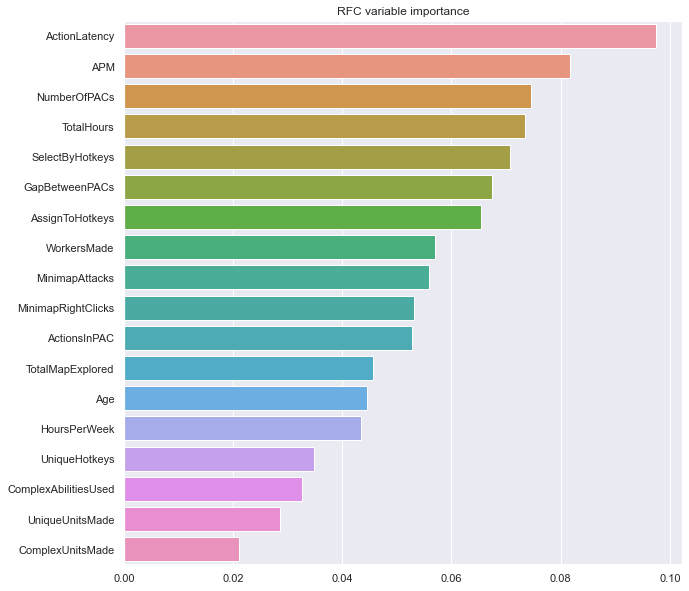

In [23]:
sorted_index_class = (-forest_class.feature_importances_).argsort()
(sns.barplot(x=forest_class.feature_importances_[sorted_index_class], y=X.columns[sorted_index_class])
            .set_title('RFC variable importance'))

Text(0.5, 1.0, 'RFC Permutation Variable Importance')

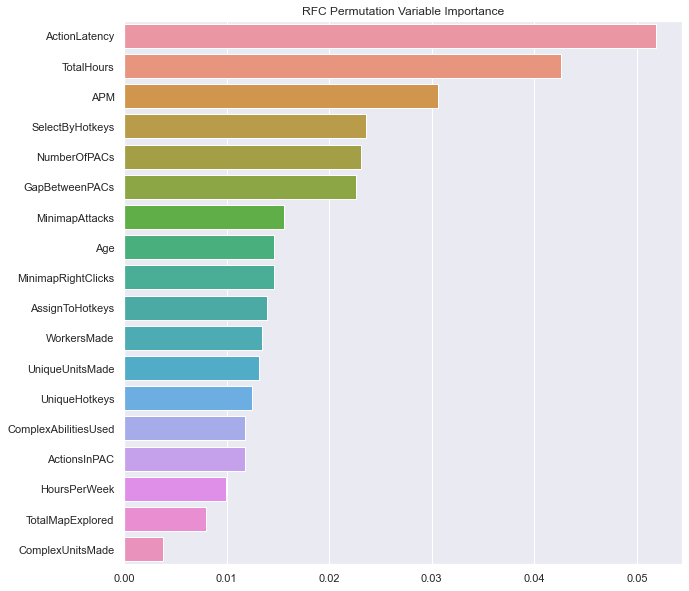

In [24]:
perm_impor_class = permutation_importance(forest_class, X_test, y_test)
perm_sort_index_class = (-perm_impor_class.importances_mean).argsort()
(sns.barplot(y=X.columns[perm_sort_index_class], x=perm_impor_class.importances_mean[perm_sort_index_class])
             .set_title('RFC Permutation Variable Importance'))

In [25]:
#Write a function that makes a classifier for each transition.
#Find the importance of each feature for each transition
def get_classifier_vars(intial, final):
    starcraft_data_ = starcraft_data_nanfree[starcraft_data_nanfree['LeagueIndex'].isin([intial, final])]
    X_ = starcraft_data_.drop(['LeagueIndex', 'GameID'], axis=1)
    y_ = starcraft_data_['LeagueIndex']
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.25, random_state=10)
    forest_class_ = RandomForestClassifier(random_state=10)
    forest_class_.fit(X_train_, y_train_)
    return forest_class_.feature_importances_
feature_importance_1to2 = get_classifier_vars(1, 2)
feature_importance_2to3 = get_classifier_vars(2, 3)
feature_importance_3to4 = get_classifier_vars(3, 4)
feature_importance_4to5 = get_classifier_vars(4, 5)
feature_importance_5to6 = get_classifier_vars(5, 6)
feature_importance_6to7 = get_classifier_vars(6, 7)

In [26]:
#Because means were used for Total Hours, Age and Hours per Week for the pro league, these rows need to
#be dropped now. 
starcraft_data_ = starcraft_data_nanfree[starcraft_data_nanfree['LeagueIndex'].isin([7, 8])]
X_ = starcraft_data_.drop(['LeagueIndex', 'GameID', 'Age', 'TotalHours', 'HoursPerWeek'], axis=1)
y_ = starcraft_data_['LeagueIndex']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.25, random_state=10)
forest_class_ = RandomForestClassifier(random_state=10)
forest_class_.fit(X_train_, y_train_)
feature_importance_7to8 = forest_class_.feature_importances_

In [27]:
#Put the feature importance into a Dataframe for easy manipulation. 
importance_df = pd.DataFrame()
def add_to_impor_df(feature_impor, column_name):
    impor = pd.Series(feature_impor, index=X.columns)
    importance_df[column_name] = impor
add_to_impor_df(feature_importance_1to2, '1to2')
add_to_impor_df(feature_importance_2to3, '2to3')
add_to_impor_df(feature_importance_3to4, '3to4')
add_to_impor_df(feature_importance_4to5, '4to5')
add_to_impor_df(feature_importance_5to6, '5to6')
add_to_impor_df(feature_importance_6to7, '6to7')

In [28]:
impor = pd.Series(feature_importance_7to8, 
                  index=X.drop(['Age', 'HoursPerWeek', 'TotalHours'], axis=1).columns)
importance_df['7to8'] = impor

In [29]:
importance_df

,1to2,2to3,3to4,4to5,5to6,6to7,7to8
Age,0.049246,0.039410,0.042403,0.034737,0.034313,0.033510,NaN
HoursPerWeek,0.035465,0.037923,0.039747,0.034583,0.050355,0.079665,NaN
TotalHours,0.068525,0.083505,0.062978,0.063418,0.071459,0.091462,NaN
APM,0.085222,0.072276,0.083897,0.086590,0.076366,0.051779,0.153428
SelectByHotkeys,0.065196,0.067485,0.060533,0.074171,0.070551,0.042914,0.165271
AssignToHotkeys,0.064127,0.065520,0.067400,0.059560,0.060965,0.092378,0.076612
UniqueHotkeys,0.030774,0.033636,0.033716,0.031118,0.033712,0.034474,0.029728
MinimapAttacks,0.033213,0.042364,0.053735,0.056770,0.058505,0.078743,0.047403
MinimapRightClicks,0.060207,0.061512,0.057523,0.052247,0.052025,0.039855,0.047859
NumberOfPACs,0.067466,0.085660,0.078853,0.076513,0.072833,0.071790,0.053854


Text(0.5, 1.0, 'Feature Importance by League Groups')

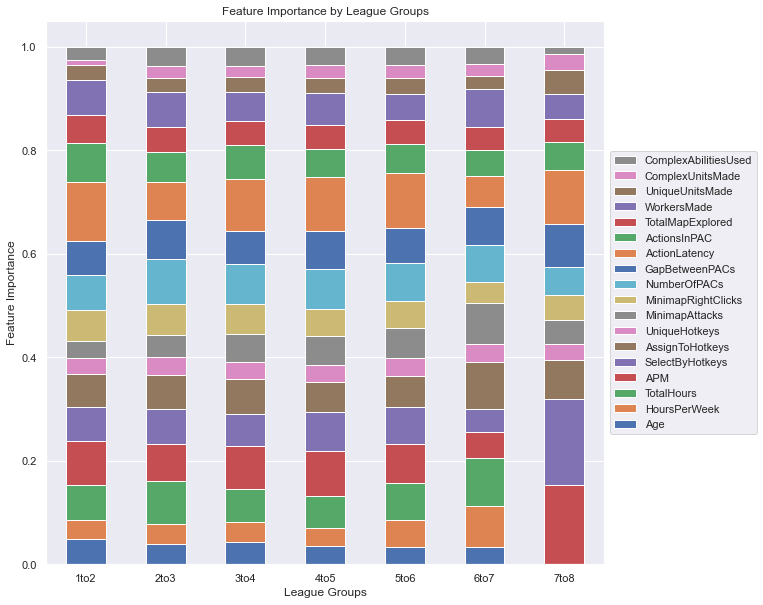

In [30]:
ax = importance_df.T.plot(kind='bar', stacked=True)
handles, labels = ax.get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel('League Groups')
plt.ylabel('Feature Importance')
plt.xticks(rotation=360)
plt.title('Feature Importance by League Groups')

In [31]:
importance_df['1to2'].nlargest(5)

ActionLatency    0.113441
APM              0.085222
ActionsInPAC     0.075832
WorkersMade      0.068671
TotalHours       0.068525
Name: 1to2, dtype: float64

In [32]:
importance_df['2to3'].nlargest(5)

NumberOfPACs      0.085660
TotalHours        0.083505
GapBetweenPACs    0.075668
ActionLatency     0.073829
APM               0.072276
Name: 2to3, dtype: float64

In [33]:
top_5_df = pd.DataFrame()
for c in importance_df.columns:
    top_5 = importance_df[c].nlargest(5)
    top_5_df = pd.concat([top_5_df, top_5], axis=1)

In [34]:
top_5_df

,1to2,2to3,3to4,4to5,5to6,6to7,7to8
ActionLatency,0.113441,0.073829,0.100376,0.104218,0.105643,NaN,0.104134
APM,0.085222,0.072276,0.083897,0.086590,0.076366,NaN,0.153428
ActionsInPAC,0.075832,NaN,0.064938,NaN,NaN,NaN,NaN
WorkersMade,0.068671,NaN,NaN,NaN,NaN,0.074923,NaN
TotalHours,0.068525,0.083505,NaN,NaN,0.071459,0.091462,NaN
NumberOfPACs,NaN,0.085660,0.078853,0.076513,0.072833,NaN,NaN
GapBetweenPACs,NaN,0.075668,NaN,0.074106,NaN,NaN,0.083515
AssignToHotkeys,NaN,NaN,0.067400,NaN,NaN,0.092378,0.076612
SelectByHotkeys,NaN,NaN,NaN,0.074171,0.070551,NaN,0.165271
HoursPerWeek,NaN,NaN,NaN,NaN,NaN,0.079665,NaN


In [35]:
#Turn each value into a percentage of the whole column
for c in top_5_df.columns: 
    top_5_df[c] = top_5_df[c]/top_5_df[c].sum()

Text(0.5, 1.0, 'Feature Importance by League Groups')

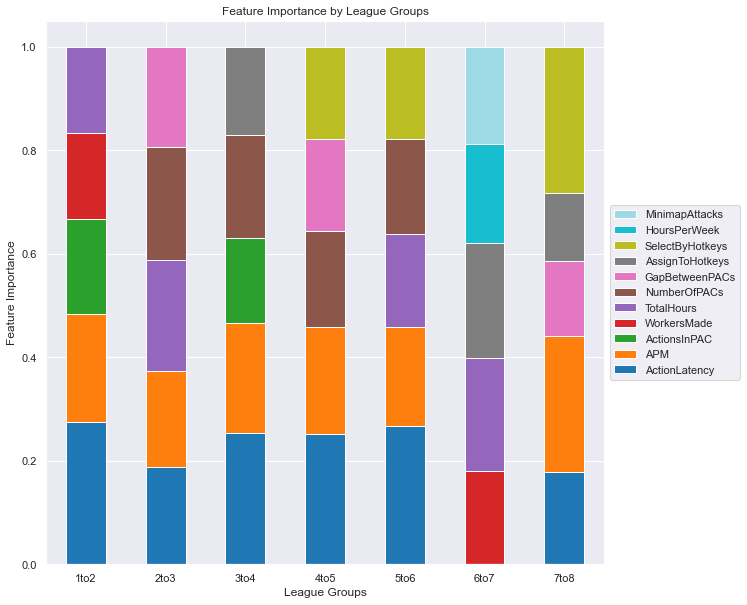

In [36]:
ax = top_5_df.T.plot(kind='bar', stacked=True, cmap='tab20')
handles, labels = ax.get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel('League Groups')
plt.ylabel('Feature Importance')
plt.xticks(rotation=360)
plt.title('Feature Importance by League Groups')